# PyGlaucoMetrics: An open-source Python repository that standardizes and assesses Visual Field (VF) data. Our repository automatically identifies signs of glaucoma based on predefined criteria.

# General overview:
# 1- Import raw VF data
df_VFs = pd.read_csv('VF_Data.csv')

# 2- Get td, tdp, pd, and pdp from PyVisualField Package.
df_td, df_tdp, df_pdp = visualFields.getallvalues(df_VFs)

# 3- Obtain required columns from each dataframe
raw_data_pdp = df_pdp.loc[:, 'l1':'l54'] raw_data_td = df_td.loc[:, 'l1':'l54'] raw_data_tdp = df_tdp.loc[:, 'l1':'l54']

# 4- Call each function and save resulted diagnosis
df_diag_HAP2 = Fn_HAP2_part2(raw_data_pdp) # it needs pdp values. will compute if necessary df_diag_UKG = Fn_UKGTS(raw_data_td) #it needs tdp values, will compute if necessary df_diag_logts = Fn_LoGTS(raw_data_tdp) # it need TD values, will compute if necessary

In [1]:
# Import Libraries
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from PyVisualFields import visualFields
from PyVisualFields import vfprogression
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="rpy2.robjects.pandas2ri")


In [2]:
# Read original and restructured data
org_data = pd.read_csv('D:/PyVisualField/VF_Data_org.csv', encoding='windows-1254')
org_data

,id,gender,eye,fieldN,age,time_from_Baseline,MS,MS_Cluster1,MS_Cluster2,MS_Cluster3,...,PD_45,PD_46,PD_47,PD_48,PD_49,PD_50,PD_51,PD_52,PD_53,PD_54
0,647,F,Right,1,52.7967,0.0000,27.832885,25.57750,26.979231,30.588333,...,-1.92,-0.36,-0.44,-1.52,-0.03,-1.06,0.75,-1.33,-2.02,-0.61
1,647,F,Right,2,53.8234,1.0267,30.131346,27.76000,29.911538,33.263333,...,-0.54,-1.13,-1.81,-1.74,-2.19,-1.23,-4.85,-2.24,0.00,0.28
2,647,F,Right,3,54.8857,2.0890,29.454808,25.47500,29.826154,32.488333,...,-0.07,1.56,-2.09,0.07,-0.84,-2.45,-0.48,-4.10,-1.28,-4.07
3,647,F,Right,4,57.7331,4.9363,27.947885,23.75625,28.658462,31.431667,...,-2.57,-1.74,-0.52,-2.70,-1.48,-3.32,-3.00,-6.49,-2.19,-2.76
4,647,F,Right,5,58.7680,5.9713,27.644038,24.90250,28.104615,30.105000,...,-0.80,-0.93,-3.08,-2.55,-3.26,-3.13,-1.42,-0.18,-1.02,-2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28938,7324,F,Left,2,65.6537,0.2163,27.471923,25.32125,25.657692,30.785000,...,0.30,-3.89,-4.68,-3.45,-0.88,-0.72,0.00,-2.81,-0.83,-2.02
28939,6859,M,Right,1,79.4114,0.0000,23.916346,26.37000,15.611538,15.225000,...,-0.43,-0.71,-3.52,0.00,-0.60,1.05,-3.96,-2.23,0.25,-2.06
28940,6859,M,Right,2,80.6598,1.2485,23.475192,23.74500,13.599231,22.355000,...,0.00,-0.85,-0.70,0.20,-0.16,-1.95,1.20,-3.11,-1.91,-0.93
28941,1142,NaN,Left,1,67.3155,0.0000,27.896923,26.95250,29.080000,30.493333,...,-4.77,-4.94,-9.38,-6.18,-2.88,-2.18,-2.61,-3.51,-2.83,-0.09


In [3]:
pd.options.mode.chained_assignment = None  # Suppresses the SettingWithCopyWarning

# Check the required columns in the data structure
required_columns = ['id', 'eye', 'date', 'time', 'age', 'type', 'fpr', 'fnr', 'fl', 'duration']

# Check if all required columns exist in the DataFrame
missing_columns = [col for col in required_columns if col not in org_data.columns]

# If any required columns are missing, add them and assign NaN to each row
if missing_columns:
    for col in reversed(required_columns):
        if col in missing_columns:
            org_data.insert(0, col, float('nan'))

# Create a new DataFrame with only the required columns in the specified order
restruc_data = org_data[required_columns + [col for col in org_data.columns if col not in required_columns]]

# Replace NaN values with 0 except for string type columns
# Define columns to exclude from filling NaNs
exclude_columns = ['gender', 'eye', 'type']

# Iterate over columns and fill NaNs with 0, excluding specified columns
for column in restruc_data.columns:
    if column not in exclude_columns:
        restruc_data.loc[:, column] = restruc_data[column].fillna(0)

# Select required columns and l1 to l54
required_columns.extend([f'l{i}' for i in range(1, 55)])
df_input = restruc_data[required_columns]
# Replace 'Right' with 'OD' and 'Left' with 'OS' in the 'eye' column
df_input['eye'].replace({'Right': 'OD', 'Left': 'OS'}, inplace=True)

# Ensure correct data types
df_input['id'] = df_input['id'].astype('int32')
df_input['age'] = df_input['age'].astype('int32')
df_input['date'] = pd.to_datetime(df_input['date'])
#df_input['time'] = df_input['time'].astype('object')  # Assuming time format is not standardized
#df_input[['fpr', 'fnr', 'fl', 'duration']] = df_input[['fpr', 'fnr', 'fl', 'duration']].astype('float64')
df_input[[f'l{i}' for i in range(1, 55)]] = df_input[[f'l{i}' for i in range(1, 55)]].astype('int32')


print(df_input)
print(df_input.dtypes)

         id eye       date  time  age  type  fpr  fnr   fl  duration  ...  \
0       647  OD 1970-01-01   0.0   52   NaN  0.0  0.0  0.0       0.0  ...   
1       647  OD 1970-01-01   0.0   53   NaN  0.0  0.0  0.0       0.0  ...   
2       647  OD 1970-01-01   0.0   54   NaN  0.0  0.0  0.0       0.0  ...   
3       647  OD 1970-01-01   0.0   57   NaN  0.0  0.0  0.0       0.0  ...   
4       647  OD 1970-01-01   0.0   58   NaN  0.0  0.0  0.0       0.0  ...   
...     ...  ..        ...   ...  ...   ...  ...  ...  ...       ...  ...   
28938  7324  OS 1970-01-01   0.0   65   NaN  0.0  0.0  0.0       0.0  ...   
28939  6859  OD 1970-01-01   0.0   79   NaN  0.0  0.0  0.0       0.0  ...   
28940  6859  OD 1970-01-01   0.0   80   NaN  0.0  0.0  0.0       0.0  ...   
28941  1142  OS 1970-01-01   0.0   67   NaN  0.0  0.0  0.0       0.0  ...   
28942  1142  OS 1970-01-01   0.0   67   NaN  0.0  0.0  0.0       0.0  ...   

       l45  l46  l47  l48  l49  l50  l51  l52  l53  l54  
0       26   29  

# Obtaining TDP and PDP using PyVisualField Package. Please install approperiate packages/libraries as described at: (https://github.com/mohaEs/PyVisualField/blob/main/readme_Installation.md)


Shape of Total Deviation:(54,)
Type of Total Deviation: <class 'tuple'>


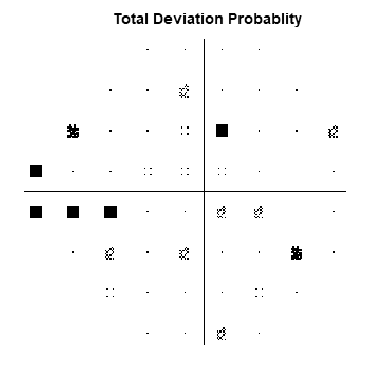

In [4]:
# Obtaining TDP and PDP using PyVisualField Package 

df_td, df_tdp, df_gi, df_gip, df_pd, df_pdp, gh = visualFields.getallvalues(df_input)#df_VFs_py data is acquired using 24-2 Vfs

ind_td_start=df_td.columns.get_loc("l1")
ind_td_end=df_td.columns.get_loc("l54") 

df_td = df_td.fillna(0)
df_tdp = df_tdp.fillna(0)

td = df_td.iloc[0,ind_td_start:ind_td_end+1].to_numpy().astype(np.int8())
print('Shape of Total Deviation:{}'.format(td.shape))
print('Type of Total Deviation:', type(td.shape))
tdp = df_tdp.iloc[0, ind_td_start:ind_td_end+1].to_numpy().astype(np.float16())
vfprogression.plotProbabilities(tdp, title= 'Total Deviation Probablity',
                                 save=True, filename='tdp', fmt='png') 

In [5]:
df_input.iloc[[22]]

,id,eye,date,time,age,type,fpr,fnr,fl,duration,...,l45,l46,l47,l48,l49,l50,l51,l52,l53,l54
22,6610,OD,1970-01-01,0.0,53,NaN,0.0,0.0,0.0,0.0,...,28,28,30,30,30,30,28,27,26,30


# vfplot: plots a single visual field test (from visualFields package)
Based on the input type, we can plot sensitivity(s), td, pd, tds (td & s), pds (pd & s) deviations maps are colorful and the colormap can be accessed by plotProbColormap Description: vfplot function also saves the photo with filename (e.g. 'file' in this example) with the format (e.g. 'png' in this example.).

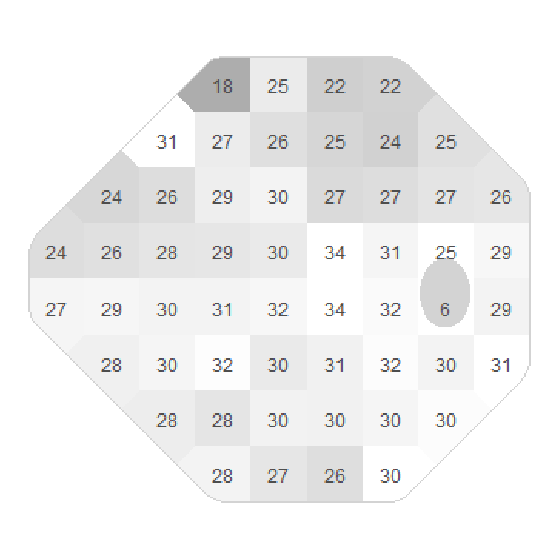

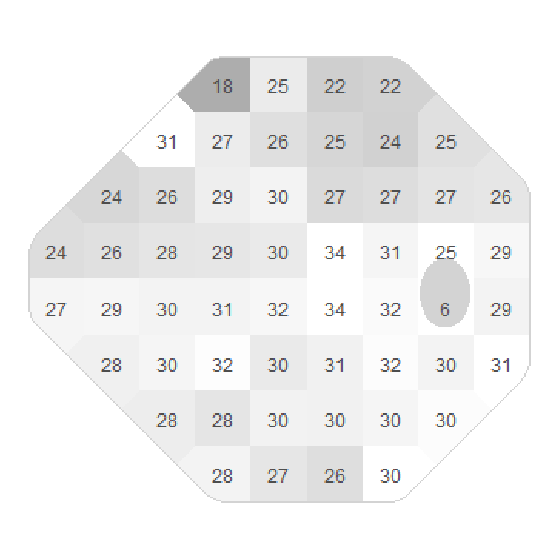

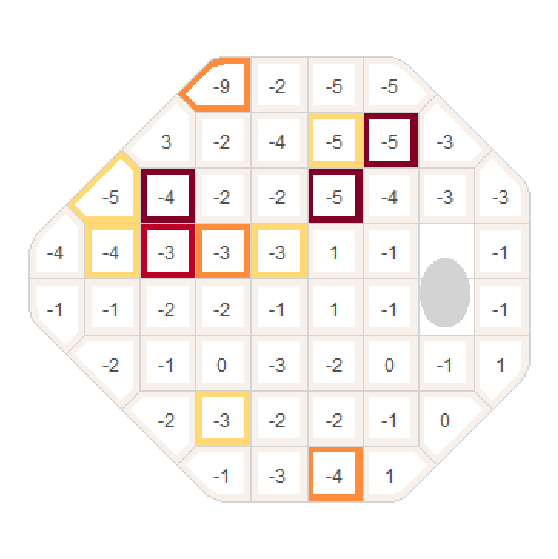

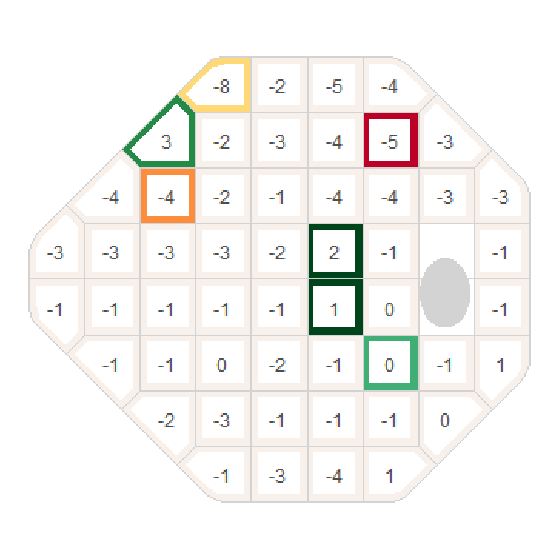

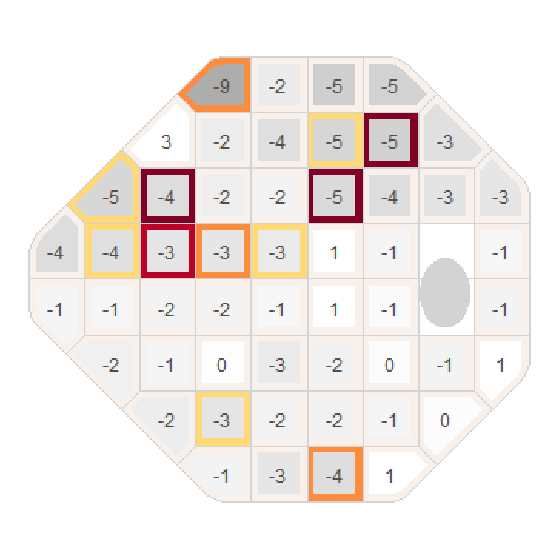

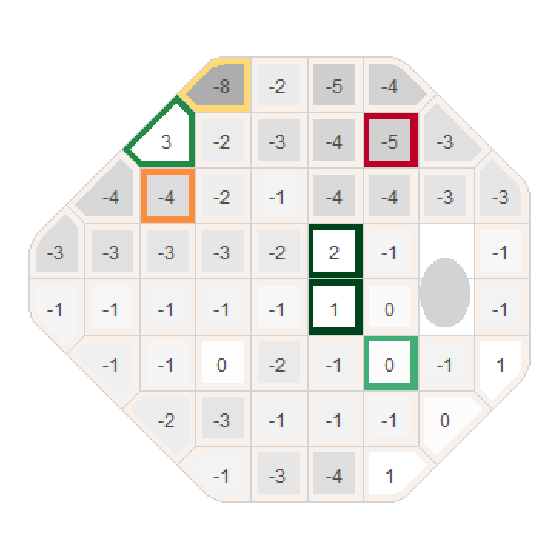

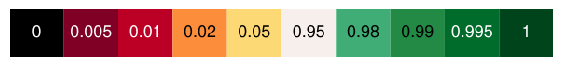

In [6]:
#df_VFs_py = visualFields.data_vfpwgRetest24d2() #df_VFs_py is acquired using vfpwgRetest24d2() function. 
df_VFs_py=df_input
vf = df_VFs_py.iloc[[22]] #Sanity check...lets pick the first VF of df_VFs_py as example

visualFields.vfplot(vf, type='s', save=True, filename='sensitivity', fmt='png') # types: s, td,pd, tds, pds
visualFields.vfplot_s(vf, save=False, filename='s', fmt='png') # alias for vfplot(type='s')
visualFields.vfplot_td(vf, save=True, filename='td', fmt='png') # alias for vfplot(type='td')
visualFields.vfplot_pd(vf, save=True, filename='pd', fmt='pdf') # alias for vfplot(type='pd')
visualFields.vfplot_tds(vf, save=True, filename='tds', fmt='png') # alias for vfplot(type='tds')
visualFields.vfplot_pds(vf, save=True, filename='pds', fmt='png') # alias for vfplot(type='pds')
visualFields.plotProbColormap(save=True, filename='cmap', fmt='pdf') # show colormap of probablies (from visualFields package)

In [7]:
vf.loc[:, 'l1':'l54']

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,l45,l46,l47,l48,l49,l50,l51,l52,l53,l54
22,18,25,22,22,31,27,26,25,24,25,...,28,28,30,30,30,30,28,27,26,30


# 0- Data pre-processing: Filling out NaN values in a row with the median of that row


In [8]:
raw_data_pdp = df_pdp.loc[:, 'l1':'l54']
raw_data_td = df_td.loc[:, 'l1':'l54']
raw_data_tdp = df_tdp.loc[:, 'l1':'l54']
# Function to fill NaN values in a row with the median of that row
def fill_nan_with_median(row):
    median_value = row.median()
    return row.fillna(median_value)

# Apply the function to each row
proc_data_pdp = raw_data_pdp.apply(fill_nan_with_median, axis=1)
proc_data_td = raw_data_td.apply(fill_nan_with_median, axis=1)
proc_data_tdp = raw_data_tdp.apply(fill_nan_with_median, axis=1)

df_PDP = proc_data_pdp
df_TD = proc_data_td
df_TDP = proc_data_tdp

# Merge the DataFrames based on the common column 'ID'
df_PDP = df_PDP.set_index(org_data.index)
df_PDP['MD'] = org_data['MTD'].values
# Filter the DataFrame for 'OD' eyes
df_PDP['eye'] = df_input['eye'] 

# 1- GHT Criteria

In [9]:

def GHT_clf(row):
    # Prepare data for sectoring: 5 sectors in superior and 5 in inferior of each VF
    if row['eye'] == 'OD':
        s_sectors = row[['l22', 'l23', 'l24', 'l13', 'l14', 'l15', 'l16', 'l11', 'l12', 'l19', 'l20', 'l21', 
                         'l1', 'l2', 'l5', 'l6', 'l7', 'l8', 'l3', 'l4', 'l9', 'l10']]
        i_sectors = row[['l31', 'l32', 'l33', 'l39', 'l40', 'l41', 'l42', 'l28', 'l29', 'l30', 'l37', 'l38', 
                         'l45', 'l46', 'l47', 'l48', 'l51', 'l52', 'l49', 'l50', 'l53', 'l54']]
    elif row['eye'] == 'OS':
        s_sectors = row[['l22', 'l23', 'l24', 'l13', 'l14', 'l15', 'l16', 'l17', 'l18', 'l25', 'l26', 'l27', 
                         'l3', 'l4', 'l8', 'l9', 'l10', 'l1', 'l2', 'l5', 'l6']]
        i_sectors = row[['l31', 'l32', 'l33', 'l39', 'l40', 'l41', 'l42', 'l34', 'l35', 'l36', 'l43', 'l44', 
                         'l48', 'l49', 'l50', 'l53', 'l54', 'l45', 'l46', 'l51', 'l52']]
    else:
        return 'Non-GL'

    # Calculate sums for each set of sectors
    s_sum = s_sectors.sum()
    i_sum = i_sectors.sum()

    # Check if the sum of values in any pair is greater than 0.005
    gl_sum_flag = (s_sum > 0.005) and (i_sum > 0.005)

    # Calculate the absolute difference between s and i sectors
    count_005 = (row.loc['l1':'l54'] <= 0.005).sum()
    diff = (s_sectors - i_sectors).abs().sum()

    # Check if the difference between individual sectors is greater than 0.01
    gl_diff_flag = diff > 0.01

    # Classify the row as GL if any condition is met, otherwise as Non-GL
    if count_005 == 0:
        return 'Non-GL'
    elif gl_sum_flag or gl_diff_flag:
        return 'GL'
    else:
        return 'Non-GL'

def Fn_GHT(df_PDP):
    # Apply the classification function to each row of the DataFrame
    df_PDP['GHT_clf'] = df_PDP.apply(GHT_clf, axis=1)

    return df_PDP

# Assuming df_PDP is the DataFrame containing the data
df_GHT = Fn_GHT(df_PDP)
print(df_GHT)

         l1    l2    l3    l4     l5     l6    l7    l8    l9   l10  ...  \
0      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
1      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
2      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
3      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.05  0.01  ...   
4      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
...     ...   ...   ...   ...    ...    ...   ...   ...   ...   ...  ...   
28938  0.95  0.95  0.95  0.95  0.050  0.005  0.95  0.95  0.95  0.95  ...   
28939  0.95  0.95  0.98  0.95  0.005  0.950  0.95  0.95  0.95  0.95  ...   
28940  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.05  0.01  0.95  ...   
28941  0.95  0.95  0.95  0.95  0.950  0.950  0.98  0.95  0.95  0.95  ...   
28942  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   

         l48   l49   l50   l51   l52   l53   l54        MD  eye  GHT_clf  
0      0.950

Non-GL     5760
GL        23183
Name: GHT_clf, dtype: int64


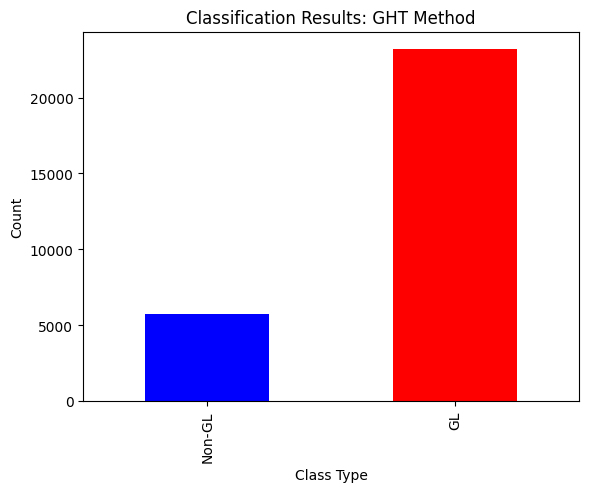

In [10]:
# Visualization GHT
# Count the occurrences of "GL" and "Non-GL"
stage_order = ['Non-GL', 'GL']

counts_ght = df_GHT['GHT_clf'].value_counts().reindex(stage_order)
print(counts_ght)
counts_ght.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: GHT Method')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 2- HAP2 Criteria

In [11]:
def Fn_HAP2(df_PDP):
    def stage_classification(row):
        # Add the count as new columns to the DataFrame
        count_05 = (row.loc['l1':'l54'] <= 0.05).sum()
        count_01 = (row.loc['l1':'l54'] <= 0.01).sum()
        row['Count_Less_Than_0.05'] = count_05
        row['Count_Less_Than_0.01'] = count_01
        if 0.01 <= abs(row['MD']) <= 6 and 1 <= row['Count_Less_Than_0.05'] <= 12 and 1 <= row['Count_Less_Than_0.01'] <= 4:
            return "Stage 1"
        elif 6.01 <= abs(row['MD']) <= 12 and 13 <= row['Count_Less_Than_0.05'] <= 26 and 5 <= row['Count_Less_Than_0.01'] <= 13:
            return "Stage 2"
        elif 12.01 <= abs(row['MD']) and row['Count_Less_Than_0.05'] >= 27 and row['Count_Less_Than_0.01'] >= 14:
            return "Stage 3"
        else:
            return "Non-GL"

    def HAP2_clf(row):
        count_05 = (row.loc['l1':'l54'] <= 0.05).sum()
        count_01 = (row.loc['l1':'l54'] <= 0.01).sum()
        if count_05 >= 3 and count_01 >= 1:
            return stage_classification(row)
        else:
            return "Non-GL"

    # Add 'HAP2_p1_clf' column based on the HAP2_clf function
    df_PDP['HAP2_p1_clf'] = df_PDP.apply(HAP2_clf, axis=1) 

    # Count the number of values less than 0.05 and 0.01 for each row
    count_05 = (df_PDP.loc[:, 'l1':'l54'] <= 0.05).sum(axis=1)
    count_01 = (df_PDP.loc[:, 'l1':'l54'] <= 0.01).sum(axis=1)

    # Apply the stage classification based on the counts
    df_PDP['HAP2_p2_clf'] = df_PDP.apply(stage_classification, axis=1)

    # Combine all stages into one class as "GL"
    df_PDP.loc[df_PDP['HAP2_p1_clf'] == "GL", "HAP2_p2_clf"] = "GL"

    # If there is a row in HAP2_p2_clf with Stage 1, Stage 2, or Stage 3, then return "GL" otherwise return the same column as HAP2_p2_clf
    df_PDP['HAP2_p1_clf'] = df_PDP.apply(lambda row: "GL" if row['HAP2_p2_clf'] in ['Stage 1', 'Stage 2', 'Stage 3'] else row['HAP2_p2_clf'], axis=1)

    return df_PDP

# Call Fn_HAP2 and show results
df_HAP2 = Fn_HAP2(df_PDP)
print(df_HAP2)


         l1    l2    l3    l4     l5     l6    l7    l8    l9   l10  ...  \
0      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
1      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
2      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
3      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.05  0.01  ...   
4      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
...     ...   ...   ...   ...    ...    ...   ...   ...   ...   ...  ...   
28938  0.95  0.95  0.95  0.95  0.050  0.005  0.95  0.95  0.95  0.95  ...   
28939  0.95  0.95  0.98  0.95  0.005  0.950  0.95  0.95  0.95  0.95  ...   
28940  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.05  0.01  0.95  ...   
28941  0.95  0.95  0.95  0.95  0.950  0.950  0.98  0.95  0.95  0.95  ...   
28942  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   

        l50   l51   l52   l53   l54        MD  eye  GHT_clf  HAP2_p1_clf  \
0      0.95

Non-GL    15171
GL        13772
Name: HAP2_p1_clf, dtype: int64


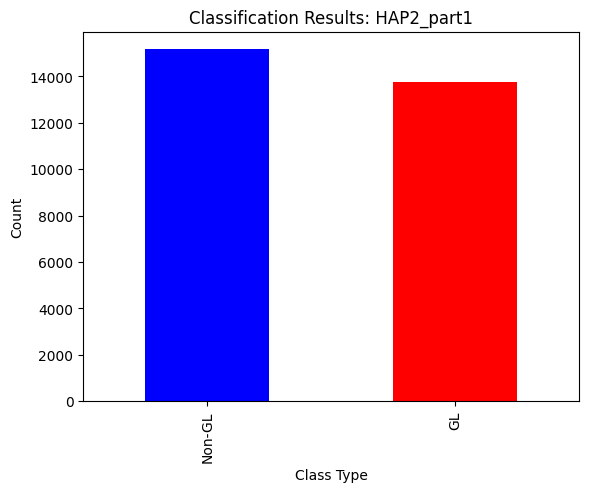

In [12]:
# Visualization df_HAP2_p1
# Count the occurrences of 'GL' and 'Non-GL'
stage_order = ['Non-GL', 'GL']

counts_hap2_p1 = df_HAP2['HAP2_p1_clf'].value_counts().reindex(stage_order)
print(counts_hap2_p1)

# Plot the bar plot
counts_hap2_p1.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: HAP2_part1')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

In [13]:
df_HAP2['HAP2_p2_clf'].iloc[[22]]

22    Stage 1
Name: HAP2_p2_clf, dtype: object

Classification Results for total eyes:
Stage 1    8456
Stage 2    1807
Stage 3    3509
Name: HAP2_p2_clf, dtype: int64


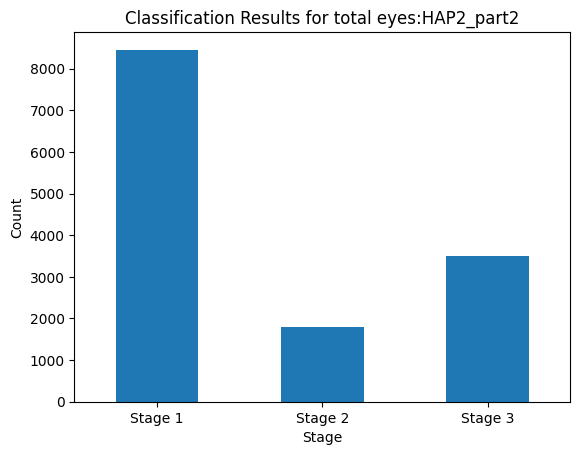

In [14]:
# 4 class classification using HAP2_part2
# Display the count of each unique value in the 'Stage' column
classification_results = df_HAP2['HAP2_p2_clf'].value_counts()
stage_order = ['Stage 1', 'Stage 2', 'Stage 3']

# Reorder the DataFrame based on the custom order
classification_results_ordered = classification_results.reindex(stage_order)

# Display the classification results
print("Classification Results for total eyes:")
print(classification_results_ordered)

import matplotlib.pyplot as plt
# Visualizing


# Plot the ordered DataFrame
classification_results_ordered.plot(kind='bar', rot=0)
plt.title('Classification Results for total eyes:HAP2_part2')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.show()

Classification Results for OD Eyes:
Stage 1    4220
Stage 2     838
Stage 3    1688
Name: HAP2_p2_clf, dtype: int64

Classification Results for OS Eyes:
Stage 1    4236
Stage 2     969
Stage 3    1821
Name: HAP2_p2_clf, dtype: int64


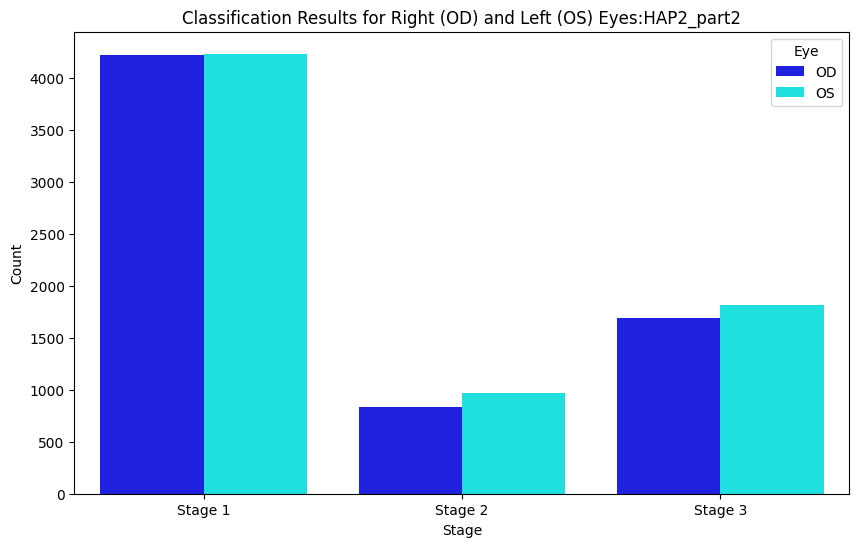

In [15]:
# Filter the DataFrame for 'OD' eyes
df_od = df_HAP2[df_HAP2['eye'] == 'OD']

# Filter the DataFrame for 'OS' eyes
df_os = df_HAP2[df_HAP2['eye'] == 'OS']
stage_order = ['Stage 1', 'Stage 2', 'Stage 3']

# Display the count of each unique value in the 'Stage' column for 'OD' eyes
classification_results_od = df_od['HAP2_p2_clf'].value_counts()
classification_results_ordered_od = classification_results_od.reindex(stage_order)

# Display the count of each unique value in the 'Stage' column for 'OS' eyes
classification_results_os = df_os['HAP2_p2_clf'].value_counts()
classification_results_ordered_os = classification_results_os.reindex(stage_order)

# Display the classification results for 'OD' eyes
print("Classification Results for OD Eyes:")
print(classification_results_ordered_od)

# Display the classification results for 'OS' eyes
print("\nClassification Results for OS Eyes:")
print(classification_results_ordered_os)

# Visualizing
# Concatenate 'OD' and 'OS' eyes into one DataFrame
df_both = pd.concat([df_od, df_os])

# Plot a bar plot with 'eye' as hue
plt.figure(figsize=(10, 6))
sns.countplot(x='HAP2_p2_clf', data=df_both, hue='eye', palette={'OD': 'blue', 'OS': 'cyan'}, order=stage_order)
plt.title('Classification Results for Right (OD) and Left (OS) Eyes:HAP2_part2')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.legend(title='Eye', loc='upper right')

# Show the plot
plt.show()

In [16]:
# save tdp and pdp into the csv file
# We need to merge these new data into the original VFs

directory_path = '/PyVisualField/Output/'
name1 = 'TDP_data'
name2 = 'PDP_data'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file_name1 = f'{name1}_{timestamp}.csv'
csv_file_name2 = f'{name2}_{timestamp}.csv'

csv_file_path1 = f'{directory_path}{csv_file_name1}'
csv_file_path2 = f'{directory_path}{csv_file_name2}'


df_tdp.to_csv(csv_file_path1, index=False)
df_pdp.to_csv(csv_file_path2, index=False)

# 4- UKGTS

In [17]:
def check_gl_condition(row, threshold=0.01, consecutive_reductions=2):
    # Convert values to numeric, handling errors by setting them to NaN
    numeric_values = pd.to_numeric(row.values, errors='coerce')
    below_threshold = numeric_values < threshold
    consecutive_counts = np.convolve(below_threshold, np.ones(consecutive_reductions), mode='valid')

    return np.any(consecutive_counts >= consecutive_reductions)

def Fn_UKGTS(df_TDP, threshold=0.01, consecutive_reductions=2):
    # Apply the condition to identify GL or Non-GL
    df_TDP['UKGTS_clf'] = np.where(df_TDP.apply(check_gl_condition, axis=1, threshold=threshold, consecutive_reductions=consecutive_reductions), 'GL', 'Non-GL')

    return df_TDP

# Assuming df_UKGTS is your DataFrame
df_UKGTS = Fn_UKGTS(df_TDP)

# Display the result
print(df_UKGTS)

         l1    l2    l3    l4    l5     l6    l7    l8     l9    l10  ...  \
1      0.95  0.95  0.95  0.95  0.95  0.950  0.02  0.95  0.950  0.950  ...   
2      0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.950  0.950  ...   
3      0.95  0.05  0.95  0.95  0.95  0.950  0.95  0.95  0.950  0.950  ...   
4      0.95  0.05  0.95  0.95  0.95  0.950  0.95  0.95  0.050  0.005  ...   
5      0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.050  0.950  ...   
...     ...   ...   ...   ...   ...    ...   ...   ...    ...    ...  ...   
28939  0.95  0.95  0.95  0.95  0.02  0.005  0.95  0.95  0.950  0.950  ...   
28940  0.95  0.95  0.95  0.95  0.05  0.950  0.95  0.95  0.950  0.950  ...   
28941  0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.05  0.005  0.950  ...   
28942  0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.050  0.950  ...   
28943  0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.950  0.950  ...   

         l46    l47    l48    l49   l50   l51   l52   l53   l54  UKGTS_clf 

Non-GL     9042
GL        19901
Name: UKGTS_clf, dtype: int64


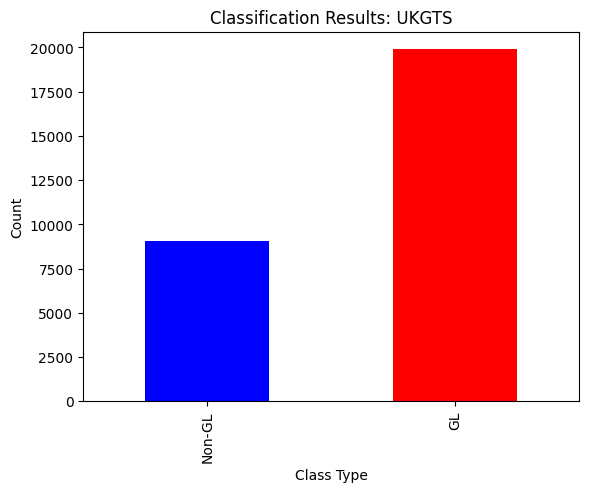

In [18]:
# Visualization UKGTS
# Count the occurrences of 'GL' and 'Non-GL'
stage_order = ['Non-GL', 'GL']

counts_ukgts = df_UKGTS['UKGTS_clf'].value_counts().reindex(stage_order)
print(counts_ukgts)

# Plot the bar plot
counts_ukgts.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: UKGTS')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 5- LoGTS

In [19]:
def LoGTS_clf(row):
    # Convert values to numeric, handling errors by setting them to NaN
    numeric_values = pd.to_numeric(row, errors='coerce')
    
    # Count values less than -10
    count_less_than_10 = (numeric_values < -10).sum()
    
    if count_less_than_10 >= 2:
        return "GL"
    else:
        return "Non-GL"

def Fn_LoGTS(df_LoGTS):
    # Add 'LoGTS_clf' column based on the LoGTS_clf function
    df_TD['LoGTS_clf'] = df_TD.apply(LoGTS_clf, axis=1)
    
    return df_TD

# Assuming df_LoGTS is your DataFrame
df_LoGTS = Fn_LoGTS(df_TD)

# Display the result
print(df_LoGTS)

             l1        l2        l3        l4        l5        l6        l7  \
1     -0.644665 -4.170592 -5.221520 -2.797450 -2.214469 -2.215394 -4.741320   
2      0.418493 -1.110465  0.839327 -0.732129 -0.151032  0.841258 -2.687700   
3     -4.518349 -6.050339 -4.099826 -3.666807  1.912405  0.897910 -1.634080   
4     -3.328875 -6.869961 -5.917284 -6.470844  1.102716 -1.932134 -2.473221   
5     -2.265716 -4.809835 -0.856437 -4.405522 -2.833847 -1.875482 -3.419601   
...         ...       ...       ...       ...       ...       ...       ...   
28939 -4.823610 -1.388952 -0.430507 -0.948274 -5.389789 -6.478919 -4.044261   
28940  2.060603  2.452813  2.421353 -5.033777 -4.501672  0.314208  1.706417   
28941 -0.876239 -0.487061 -4.517800 -5.968456 -1.438235 -1.629141 -2.239963   
28942  1.302706  1.731300 -0.308813 -0.817631  0.737085  0.634385  1.062978   
28943 -2.697294 -0.268700  1.691187  1.182369 -1.262915 -1.365615  1.062978   

             l8        l9       l10  ...       l46 

Non-GL    15596
GL        13347
Name: LoGTS_clf, dtype: int64


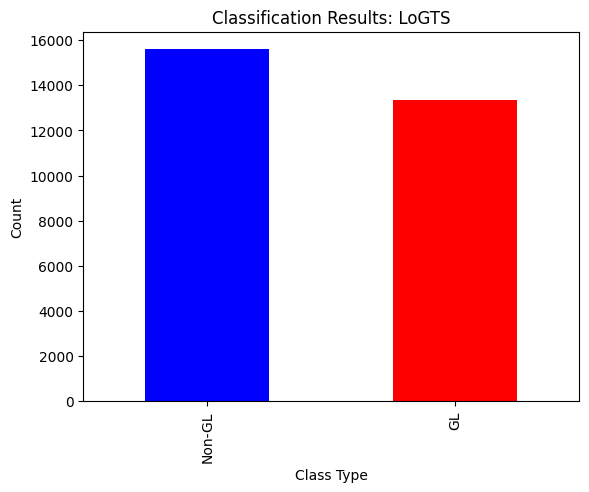

In [20]:
# Visualization LoGTS
# Count the occurrences of "GL" and "Non-GL"
stage_order = ['Non-GL', 'GL']

counts_logts = df_LoGTS['LoGTS_clf'].value_counts().reindex(stage_order)
print(counts_logts)
counts_logts.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: LoGTS')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 6- Kang's Method: https://iovs.arvojournals.org/article.aspx?articleid=2279162

In [21]:
def Kangs_clf(row):
    # Convert values to numeric, handling errors by setting them to NaN
    numeric_values = pd.to_numeric(row, errors='coerce')
    
    # Count values less than -5
    count_less_than_5 = (numeric_values < -5).sum()
    
    if count_less_than_5 >= 3:
        return "GL"
    else:
        return "Non-GL"

def Fn_Kangs(row):
    df_TD['Kangs_clf'] = df_TD.apply(Kangs_clf, axis=1)
    
    return df_TD

df_Kangs = Fn_Kangs(df_TD)

# Display the result
print(df_Kangs)

             l1        l2        l3        l4        l5        l6        l7  \
1     -0.644665 -4.170592 -5.221520 -2.797450 -2.214469 -2.215394 -4.741320   
2      0.418493 -1.110465  0.839327 -0.732129 -0.151032  0.841258 -2.687700   
3     -4.518349 -6.050339 -4.099826 -3.666807  1.912405  0.897910 -1.634080   
4     -3.328875 -6.869961 -5.917284 -6.470844  1.102716 -1.932134 -2.473221   
5     -2.265716 -4.809835 -0.856437 -4.405522 -2.833847 -1.875482 -3.419601   
...         ...       ...       ...       ...       ...       ...       ...   
28939 -4.823610 -1.388952 -0.430507 -0.948274 -5.389789 -6.478919 -4.044261   
28940  2.060603  2.452813  2.421353 -5.033777 -4.501672  0.314208  1.706417   
28941 -0.876239 -0.487061 -4.517800 -5.968456 -1.438235 -1.629141 -2.239963   
28942  1.302706  1.731300 -0.308813 -0.817631  0.737085  0.634385  1.062978   
28943 -2.697294 -0.268700  1.691187  1.182369 -1.262915 -1.365615  1.062978   

             l8        l9       l10  ...       l47 

Non-GL     9030
GL        19913
Name: Kangs_clf, dtype: int64


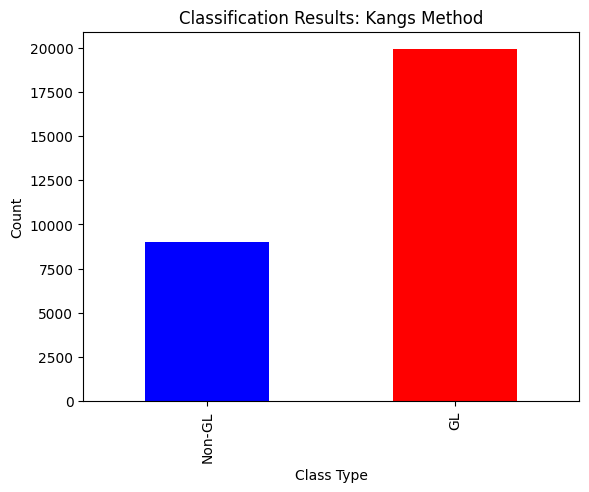

In [22]:
# Visualization Kangs
# Count the occurrences of "GL" and "Non-GL"
stage_order = ['Non-GL', 'GL']

counts_kangs = df_Kangs['Kangs_clf'].value_counts().reindex(stage_order)
print(counts_kangs)
counts_kangs.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: Kangs Method')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 7- Foster

In [23]:
def Foster_clf_condition1(row):
    if row['eye'] == 'OD':
        s_sectors = row[['l22', 'l23', 'l24', 'l13', 'l14', 'l15', 'l16', 'l11', 'l12', 'l19', 'l20', 'l21', 
                         'l1', 'l2', 'l5', 'l6', 'l7', 'l8', 'l3', 'l4', 'l9', 'l10']]
        i_sectors = row[['l31', 'l32', 'l33', 'l39', 'l40', 'l41', 'l42', 'l28', 'l29', 'l30', 'l37', 'l38', 
                         'l45', 'l46', 'l47', 'l48', 'l51', 'l52', 'l49', 'l50', 'l53', 'l54']]
    elif row['eye'] == 'OS':
        s_sectors = row[['l22', 'l23', 'l24', 'l13', 'l14', 'l15', 'l16', 'l17', 'l18', 'l25', 'l26', 'l27', 
                         'l3', 'l4', 'l8', 'l9', 'l10', 'l1', 'l2', 'l5', 'l6']]
        i_sectors = row[['l31', 'l32', 'l33', 'l39', 'l40', 'l41', 'l42', 'l34', 'l35', 'l36', 'l43', 'l44', 
                         'l48', 'l49', 'l50', 'l53', 'l54', 'l45', 'l46', 'l51', 'l52']]
    else:
        return 'Non-GL'

    # Calculate sums for each set of sectors
    s_sum = s_sectors.sum()
    i_sum = i_sectors.sum()

    # Check if the sum of values in any pair is greater than 0.005
    gl_sum_flag = (s_sum > 0.005) and (i_sum > 0.005)

    # Calculate the absolute difference between s and i sectors
    diff = (s_sectors - i_sectors).abs().sum()

    # Check if the difference between individual sectors is greater than 0.01
    gl_diff_flag = diff > 0.01

    return gl_sum_flag or gl_diff_flag

def Foster_clf_condition2(row):
    count_05 = (row.loc['l1':'l54'] <= 0.05).sum()
    return count_05 >= 3

def Fn_Foster(input_1):
    # Apply Foster classification function to input_dataset1 (condition 1)
    df_Foster_condition1 = input_1.apply(Foster_clf_condition1, axis=1)
    
    # Apply Foster classification function to input_dataset2 (condition 2)
    df_Foster_condition2 = input_1.apply(Foster_clf_condition2, axis=1)
    
    # Combine the results into a single DataFrame with Foster_clf column
    df_Foster = pd.DataFrame({'Foster_clf_condition1': df_Foster_condition1, 'Foster_clf_condition2': df_Foster_condition2})
    
    # Classify rows as "GL" if both conditions are met, otherwise "Non-GL"
    df_Foster['Foster_clf'] = 'Non-GL'
    df_Foster.loc[(df_Foster['Foster_clf_condition1'] & df_Foster['Foster_clf_condition2']), 'Foster_clf'] = 'GL'
    
    # Drop the intermediate columns
    df_Foster.drop(['Foster_clf_condition1', 'Foster_clf_condition2'], axis=1, inplace=True)
    
    return df_Foster

# Assuming input_dataset1 is result_df_segments
df_Foster = Fn_Foster(df_PDP)

# Display the result
print(df_Foster)

      Foster_clf
0         Non-GL
1         Non-GL
2             GL
3             GL
4             GL
...          ...
28938         GL
28939         GL
28940         GL
28941         GL
28942         GL

[28943 rows x 1 columns]


Non-GL     4897
GL        24046
Name: Foster_clf, dtype: int64


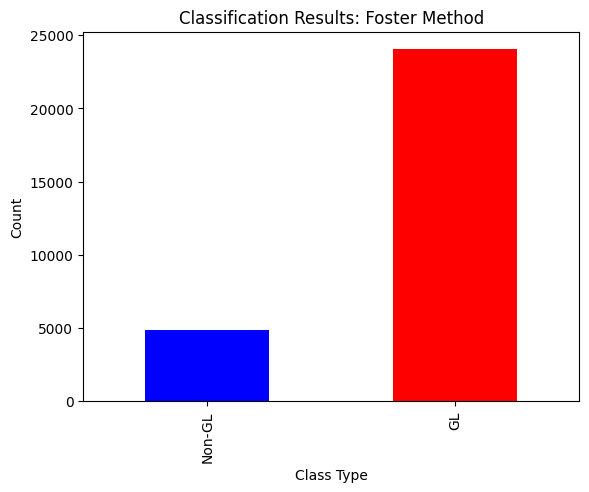

In [24]:
# Visualization Foster
# Count the occurrences of "GL" and "Non-GL"
stage_order = ['Non-GL', 'GL']

counts_foster = df_Foster['Foster_clf'].value_counts().reindex(stage_order)
print(counts_foster)
counts_foster.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: Foster Method')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# Comparing results........ Checking agreement or disagreement.... Intraclass Correlation Coefficient (ICC) was used

In [25]:
tot_counts = pd.DataFrame({
    'GHT_clf': counts_ght,
    'HAP2_p1_clf': counts_hap2_p1,
    #'HAP2_p2_clf': counts_hap2_p2,
    'UKGTS_clf': counts_ukgts,
    'LoGTS_clf': counts_logts,
    'Kangs_clf': counts_kangs,
    'Foster_clf': counts_foster

})
print("Classification Results:")
print(tot_counts)

Classification Results:
        GHT_clf  HAP2_p1_clf  UKGTS_clf  LoGTS_clf  Kangs_clf  Foster_clf
Non-GL     5760        15171       9042      15596       9030        4897
GL        23183        13772      19901      13347      19913       24046


Classification results
        GHT_clf  HAP2_p1_clf  UKGTS_clf  LoGTS_clf  Kangs_clf  Foster_clf
Non-GL     5760        15171       9042      15596       9030        4897
GL        23183        13772      19901      13347      19913       24046


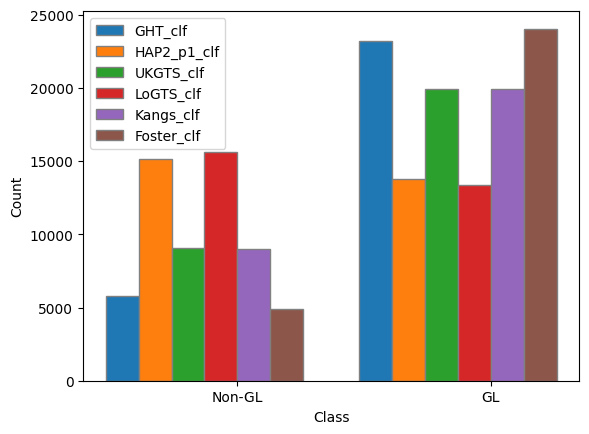

In [26]:
# Plot all methods in one graph
categories = ['Non-GL', 'GL']
print('Classification results')
print(tot_counts)
# Bar width
bar_width = 0.13

# Set up positions for bars on x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]


# Create bar plots
plt.bar(r1, counts_ght, width=bar_width, edgecolor='grey', label='GHT_clf')
plt.bar(r2, counts_hap2_p1, width=bar_width, edgecolor='grey', label='HAP2_p1_clf')
#plt.bar(r3, counts_hap2_p2, width=bar_width, edgecolor='grey', label='HAP2_p2_clf')
plt.bar(r3, counts_ukgts, width=bar_width, edgecolor='grey', label='UKGTS_clf')
plt.bar(r4, counts_logts, width=bar_width, edgecolor='grey', label='LoGTS_clf')
plt.bar(r5, counts_kangs, width=bar_width, edgecolor='grey', label='Kangs_clf')
plt.bar(r6, counts_foster, width=bar_width, edgecolor='grey', label='Foster_clf')

# Labeling
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([r + 3.5*bar_width for r in range(len(categories))], categories)

# Add legend
plt.legend()

plt.savefig('imshow_plot.png')
# Show the plot
plt.show()

In [27]:
# Check agreement/disagreement
# Intraclass Correlation Coefficient (ICC) 
non_gl_all = [counts_hap2_p1.get('Non-GL', 0), counts_ukgts.get('Non-GL', 0), counts_logts.get('Non-GL', 0), counts_kangs.get('Non-GL', 0), counts_foster.get('Non-GL', 0), counts_ght.get('Non-GL', 0)]
gl_all = [counts_hap2_p1.get('GL', 0), counts_ukgts.get('GL', 0), counts_logts.get('GL', 0), counts_kangs.get('GL', 0), counts_foster.get('GL', 0), counts_ght.get('GL', 0)]
#1- UKGTS & LoGTS
non_gl_ukgts_logts = [counts_ukgts.get('Non-GL', 0), counts_logts.get('Non-GL', 0)]
gl_ukgts_logts = [counts_ukgts.get('GL', 0), counts_logts.get('GL', 0)]
#2- HAP2_part1 & UKGTS
non_gl_hap2p1_ukgts = [counts_hap2_p1.get('Non-GL', 0), counts_ukgts.get('Non-GL', 0)]
gl_hap2p1_ukgts = [counts_hap2_p1.get('GL', 0), counts_ukgts.get('GL', 0)]
#3- HAP2_part1 & LoGTS
non_gl_hap2p1_logts = [counts_hap2_p1.get('Non-GL', 0), counts_logts.get('Non-GL', 0)]
gl_hap2p1_logts = [counts_hap2_p1.get('GL', 0), counts_logts.get('GL', 0)]
#4- HAP2_part1 & Kangs
non_gl_hap2p1_kangs = [counts_hap2_p1.get('Non-GL', 0), counts_kangs.get('Non-GL', 0)]
gl_hap2p1_kangs = [counts_hap2_p1.get('GL', 0), counts_kangs.get('GL', 0)]
#5- Kangs & UKGTS
non_gl_kangs_ukgts = [counts_kangs.get('Non-GL', 0), counts_ukgts.get('Non-GL', 0)]
gl_kangs_ukgts = [counts_kangs.get('GL', 0), counts_ukgts.get('GL', 0)]
#6- HAP2_part1 & Foster
non_gl_hap2p1_foster = [counts_hap2_p1.get('Non-GL', 0), counts_foster.get('Non-GL', 0)]
gl_hap2p1_foster = [counts_hap2_p1.get('GL', 0), counts_foster.get('GL', 0)]
#7- HAP2_part1 & GHT
non_gl_hap2p1_ght = [counts_hap2_p1.get('Non-GL', 0), counts_ght.get('Non-GL', 0)]
gl_hap2p1_ght = [counts_hap2_p1.get('GL', 0), counts_ght.get('GL', 0)]

# Combine the data into a list of arrays
data_all = [non_gl_all, gl_all]
data_ukgts_logts = [non_gl_ukgts_logts, gl_ukgts_logts]
data_hap2p1_ukgts = [non_gl_hap2p1_ukgts, gl_hap2p1_ukgts]
data_hap2p1_logts = [non_gl_hap2p1_logts, gl_hap2p1_logts]
data_hap2p1_kangs = [non_gl_hap2p1_kangs, gl_hap2p1_kangs]
data_kangs_ukgts = [non_gl_kangs_ukgts, gl_kangs_ukgts]
data_hap2p1_foster = [non_gl_hap2p1_foster, gl_hap2p1_foster]
data_hap2p1_ght = [non_gl_hap2p1_ght, gl_hap2p1_ght]

# Perform one-way ANOVA to obtain the total variance
total_variance_all = np.var(np.concatenate(data_all))
total_variance_ukgts_logts = np.var(np.concatenate(data_ukgts_logts))
total_variance_hap2p1_ukgts = np.var(np.concatenate(data_hap2p1_ukgts))
total_variance_hap2p1_logts = np.var(np.concatenate(data_hap2p1_logts))
total_variance_hap2p1_kangs = np.var(np.concatenate(data_hap2p1_kangs))
total_variance_kangs_ukgts = np.var(np.concatenate(data_kangs_ukgts))
total_variance_hap2p1_foster = np.var(np.concatenate(data_hap2p1_foster))
total_variance_hap2p1_ght = np.var(np.concatenate(data_hap2p1_ght))

# Calculate the residual variance (within-group variance)
residual_variance_all = np.mean([np.var(arr) for arr in data_all])
residual_variance_ukgts_logts = np.mean([np.var(arr) for arr in data_ukgts_logts])
residual_variance_hap2p1_ukgts = np.mean([np.var(arr) for arr in data_hap2p1_ukgts])
residual_variance_hap2p1_logts = np.mean([np.var(arr) for arr in data_hap2p1_logts])
residual_variance_hap2p1_kangs = np.mean([np.var(arr) for arr in data_hap2p1_kangs])
residual_variance_kangs_ukgts = np.mean([np.var(arr) for arr in data_kangs_ukgts])
residual_variance_hap2p1_foster = np.mean([np.var(arr) for arr in data_hap2p1_foster])
residual_variance_hap2p1_ght = np.mean([np.var(arr) for arr in data_hap2p1_ght])

# Calculate the ICC
icc_all = (total_variance_all - residual_variance_all) / total_variance_all
icc_ukgts_logts = (total_variance_ukgts_logts - residual_variance_ukgts_logts) / total_variance_ukgts_logts
icc_hap2p1_ukgts = (total_variance_hap2p1_ukgts - residual_variance_hap2p1_ukgts) / total_variance_hap2p1_ukgts
icc_hap2p1_logts = (total_variance_hap2p1_logts - residual_variance_hap2p1_logts) / total_variance_hap2p1_logts
icc_hap2p1_kangs = (total_variance_hap2p1_kangs - residual_variance_hap2p1_kangs) / total_variance_hap2p1_kangs
icc_kangs_ukgts = (total_variance_kangs_ukgts - residual_variance_kangs_ukgts) / total_variance_kangs_ukgts
icc_hap2p1_foster = (total_variance_hap2p1_foster - residual_variance_hap2p1_foster) / total_variance_hap2p1_foster
icc_hap2p1_ght = (total_variance_hap2p1_ght - residual_variance_hap2p1_ght) / total_variance_hap2p1_ght

icc_values = {
    "UKGTS and LoGTS": icc_ukgts_logts,
    "HAP2_part1 and UKGTS": icc_hap2p1_ukgts,
    "HAP2_part1 and LoGTS": icc_hap2p1_logts,
    #"HAP2_part2 and UKGTS": icc_hap2p2_ukgts,
    #"HAP2_part2 and LoGTS": icc_hap2p2_logts,
    "HAP2_part1 and Kangs": icc_hap2p1_kangs,
    "Kangs and UKGTS": icc_kangs_ukgts,
    "HAP2_part1 and Foster": icc_hap2p1_foster,
    "HAP2_part1 and GHT": icc_hap2p1_ght
}

# Find the pair with the highest ICC
best_pair = max(icc_values, key=icc_values.get)
best_icc = icc_values[best_pair]
# Print the result
print("\033[1mTotal Intraclass Correlation Coefficient (ICC):\033[0m")
print(f"All Criteria ICC= {icc_all}")
# Print the ICC results
print("\033[1mPair Intraclass Correlation Coefficient (ICC):\033[0m")
for pair, icc in icc_values.items():
    print(f"{pair} ICC= {icc}")
print("\033[1mPair Intraclass Correlation Coefficient (ICC):\033[0m")
print(f"\033[1mThe pair with the highest ICC is {best_pair} with an ICC of {best_icc}.\033[0m")

Total Intraclass Correlation Coefficient (ICC):
All Criteria ICC= 0.5451534223548961
Pair Intraclass Correlation Coefficient (ICC):
UKGTS and LoGTS ICC= 0.3014091006885399
HAP2_part1 and UKGTS ICC= 0.37327023475988114
HAP2_part1 and LoGTS ICC= 0.9485046902427043
HAP2_part1 and Kangs ICC= 0.3735406122201329
Kangs and UKGTS ICC= 0.9999987815071885
HAP2_part1 and Foster ICC= 0.4273292395952856
HAP2_part1 and GHT ICC= 0.420218230584221
Pair Intraclass Correlation Coefficient (ICC):
The pair with the highest ICC is Kangs and UKGTS with an ICC of 0.9999987815071885.


# All criteria in one function and make Ensemble majority voting classifier

In [28]:
def combine_dataframes(org_str, df1, df2, df3, df4, df5, df6):
     # Combine the DataFrames along the columns axis
    result_combined = pd.concat([df1, df2], axis=1)
    
    # Reset indices to ensure proper alignment
    m1_reset = org_str.reset_index(drop=True)
    m2_reset = result_combined.reset_index(drop=True)
    
    # Add the specified columns from m1_reset to the first three columns of m2_reset
    m2_reset.insert(0, 'ID', m1_reset['id'])
    m2_reset.insert(1, 'Eye', m1_reset['eye'])
    m2_reset.insert(2, 'Age', m1_reset['age'])
    
    result_combined = m2_reset
    
    # Concatenate df3
    result_combined = pd.concat([result_combined, df3.reset_index(drop=True)], axis=1)
    
    # Concatenate df4
    result_combined = pd.concat([result_combined, df4.reset_index(drop=True)], axis=1)
    
    # Concatenate df5
    result_combined = pd.concat([result_combined, df5.reset_index(drop=True)], axis=1)
    # Concatenate df6
    result_combined = pd.concat([result_combined, df6.reset_index(drop=True)], axis=1)
    # Concatenate df7
    #result_combined = pd.concat([result_combined, df7.reset_index(drop=True)], axis=1)
    # Return the combined DataFrame
    return result_combined

# Call the function with your DataFrames
result_combined = combine_dataframes(df_input, df_UKGTS['UKGTS_clf'], df_LoGTS['LoGTS_clf'], df_GHT['GHT_clf'], df_Foster['Foster_clf'], df_Kangs['Kangs_clf'], df_HAP2['HAP2_p1_clf'])

# Map categorical values to numeric equivalents for all columns except the first three
for column in result_combined.columns[3:]:
    result_combined[column] = result_combined[column].map({'GL': 1, 'Non-GL': 0})

# Convert data type to string to ensure consistency
result_combined_en = result_combined.astype(str)

# Normalize ICC values
icc_values=[0.5, 0.5, 0.5, 5, 0.5, 0.5]
icc_weights = np.array(icc_values) / np.sum(icc_values)

def Fn_ensemble_decision(result_combined_en, icc_weights):
    # Calculate weighted average of predictions
    predictions = result_combined_en.iloc[:, 3:].apply(pd.to_numeric, errors='coerce').fillna(0)
    result_combined['Ensemble'] = np.average(predictions, axis=1, weights=icc_weights)
    
    return result_combined

# Apply ensemble decision and calculate probabilities
result_combined = Fn_ensemble_decision(result_combined_en, icc_weights)
ensemble=result_combined['Ensemble']
ensemble_name = ensemble.name
value=ensemble.values[0]  # Assuming stage is the first value in the Series
# Define a function to map Ensemble values to 'GL' or 'Non-GL' based on the condition
def map_decision(value):
    if value > 0.5:
        return 'GL'
    else:
        return 'Non-GL'

# Apply the function to create the 'Decision' column
result_combined['Decision'] = result_combined['Ensemble'].apply(map_decision)

# Show the updated DataFrame
print(result_combined)
# Show the combined DataFrame
print(result_combined)


         ID Eye  Age  UKGTS_clf  LoGTS_clf  GHT_clf  Foster_clf  Kangs_clf  \
0       647  OD   52          1          0        0           0          1   
1       647  OD   53          0          0        0           0          0   
2       647  OD   54          0          0        1           1          1   
3       647  OD   57          1          0        1           1          1   
4       647  OD   58          1          0        1           1          1   
...     ...  ..  ...        ...        ...      ...         ...        ...   
28938  7324  OS   65          0          0        1           1          1   
28939  6859  OD   79          1          1        1           1          1   
28940  6859  OD   80          1          1        1           1          1   
28941  1142  OS   67          1          0        1           1          1   
28942  1142  OS   67          1          0        1           1          1   

       HAP2_p1_clf  Ensemble Decision  
0                0  0.1

In [32]:
# Check some IDs
ensemble=result_combined.iloc[[220]]
ensemble_name = ensemble['Decision'].values[0]
ensemble_prob= ensemble['Ensemble'].values[0]

gl_prob=round(100*ensemble_prob, 2)
ngl_prob= 100-gl_prob

print(f"Ensemble: {ensemble_name}\n"
                f"GL Probability= {gl_prob}%\n"
                f"Non-Glaucoma= {ngl_prob}%")

Ensemble: GL
GL Probability= 80.0%
Non-Glaucoma= 20.0%


# Show the final results of each function

In [33]:
# 1- GHT function
print("\nResult of Fn_GHT:")
print(Fn_GHT(df_PDP))
# 2- HAP2 function
print("\nResult of Fn_HAP2:")
print(Fn_HAP2(df_PDP))
# 3- HAP2_p2 function
#print("\nResult of Fn_HAP2_p2:")
#print(Fn_HAP2_part2(df_PDP))
# 3- UKGTS fucntion
print("Result of Fn_UKGTS:")
print(Fn_UKGTS(df_TDP))
# 4- LoGTS function
print("\nResult of Fn_LoGTS:")
print(Fn_LoGTS(df_TD))
# 5- Kangs fucntion
print("\nResult of Fn_Kangs:")
print(Fn_Kangs(df_TD))
# 6- Foster fucntion
print("\nResult of Fn_Foster:")
print(Fn_Foster(df_PDP))
# 7- Ensemble 
print("\nResult of Ensemble:")
print(Fn_ensemble_decision(result_combined_en))


Result of Fn_GHT:
         l1    l2    l3    l4     l5     l6    l7    l8    l9   l10  ...  \
0      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
1      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
2      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
3      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.05  0.01  ...   
4      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
...     ...   ...   ...   ...    ...    ...   ...   ...   ...   ...  ...   
28938  0.95  0.95  0.95  0.95  0.050  0.005  0.95  0.95  0.95  0.95  ...   
28939  0.95  0.95  0.98  0.95  0.005  0.950  0.95  0.95  0.95  0.95  ...   
28940  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.05  0.01  0.95  ...   
28941  0.95  0.95  0.95  0.95  0.950  0.950  0.98  0.95  0.95  0.95  ...   
28942  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   

        l50   l51   l52   l53   l54        MD  eye  GHT_clf  HAP2_p1

TypeError: Fn_ensemble_decision() missing 1 required positional argument: 'icc_weights'

In [ ]:
#Save classification results
# save tdp and pdp into the csv file
# We need to merge these new data into the original VFs

directory_path = '/PyVisualField/Output/'
name1 = 'GHT_clf'
name2 = 'HAP2_clf'
#name3 = 'HAP2_part2_clf'
name3 = 'UKGTS_clf'
name4 = 'LoGTS_clf'
name5 = 'Kangs_clf'
name6 = 'Foster_clf'
name7 = 'Ensemble'

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file_name1 = f'{name1}_{timestamp}.csv'
csv_file_name2 = f'{name2}_{timestamp}.csv'
csv_file_name3 = f'{name3}_{timestamp}.csv'
csv_file_name4 = f'{name4}_{timestamp}.csv'
csv_file_name5 = f'{name5}_{timestamp}.csv'
csv_file_name6 = f'{name6}_{timestamp}.csv'
csv_file_name7 = f'{name7}_{timestamp}.csv'
#csv_file_name8 = f'{name8}_{timestamp}.csv'

csv_file_path1 = f'{directory_path}{csv_file_name1}'
csv_file_path2 = f'{directory_path}{csv_file_name2}'
csv_file_path3 = f'{directory_path}{csv_file_name3}'
csv_file_path4 = f'{directory_path}{csv_file_name4}'
csv_file_path5 = f'{directory_path}{csv_file_name5}'
csv_file_path6 = f'{directory_path}{csv_file_name6}'
csv_file_path7 = f'{directory_path}{csv_file_name7}'
#csv_file_path8 = f'{directory_path}{csv_file_name8}'

Fn_GHT(df_PDP).to_csv(csv_file_path1, index=False)
Fn_HAP2(df_PDP).to_csv(csv_file_path2, index=False)
#Fn_HAP2_part2(df_PDP).to_csv(csv_file_path3, index=False)
Fn_UKGTS(df_TDP).to_csv(csv_file_path3, index=False)
Fn_LoGTS(df_TD).to_csv(csv_file_path4, index=False)
Fn_Kangs(df_TD).to_csv(csv_file_path5, index=False)
Fn_Foster(df_PDP).to_csv(csv_file_path6, index=False)

Fn_ensemble_decision(result_combined_en, icc_weights).to_csv(csv_file_path7, index=False)


In [ ]:
# Histogram
plt.hist(result_combined['Ensemble'], bins=2, edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Ensemble Probabilities')
plt.show()